In [38]:
# Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
from joblib import dump, load

In [2]:
# Загружаем данные
df = pd.read_csv('df.csv')
df.head()

,is_fraud,transaction_amount,relative_timestamp,F1,F2,F3,F4,F5,F6,F7,...,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30
0,0,118.44,159609.0,1.928977,-0.745709,-1.742981,-0.247731,-0.379232,-1.504379,0.426988,...,-0.096171,0.153526,-0.001283,0.631590,0.130582,0.758711,-0.113741,-0.063939,0.795595,-2.200074
1,0,1.98,162525.0,2.060450,-0.136926,-1.085910,0.430300,-0.254977,-1.247417,0.104193,...,-0.302288,-0.795267,0.355477,0.013651,-0.340015,0.199361,-0.078557,-0.062377,0.921937,0.216959
2,0,103.00,58956.0,1.114014,-1.533296,0.741385,-1.385897,-1.241643,1.088519,-1.433041,...,0.140363,0.783574,0.082555,-0.615175,-0.036441,-0.006456,0.109368,0.032635,0.225000,-2.467540
3,0,16.70,148842.0,0.514410,1.389934,-1.091181,1.604760,0.460984,-0.381953,-0.599145,...,-1.670931,-0.854670,0.130428,0.789378,0.909599,-0.692159,-0.033316,0.096833,0.586722,1.187643
4,0,110.14,125542.0,-0.849330,0.399191,-0.319642,-1.220384,1.062371,1.752440,0.558836,...,0.134113,0.278606,0.198983,-0.936208,-0.477630,-0.087217,0.035566,0.090183,0.569712,-1.485808


In [3]:
# Размер матрицы
df.shape

(284807, 33)

In [4]:
# Очищаем данные от Na значений
df.dropna(inplace=True)
df.shape

(273152, 33)

In [5]:
# Смотрим распределения классов
df['is_fraud'].value_counts()

0    272660
1       492
Name: is_fraud, dtype: int64

In [6]:
percentage = df['is_fraud'].value_counts()[1] / (df['is_fraud'].value_counts()[0] + df['is_fraud'].value_counts()[1]) * 100
percentage

0.1801194939081537

Как видим, у нас менее 0.2% фродовых транзакций. Это задача классификации с неравномерным распределениям классов
Для реальной задачи нам надо больше данных. У нас только 492 объекта класса '1', что говорит о недостаточном количестве данных.

У нас будет 2 важных метрики: recall и precision. Поскольку у нас сильный дисбаланс классов, нам лучше лишний раз проверить транзакцию, которая не есть фродом, чем пропустить фродовою транзакцию. По этому, recall будет иметь в нас больший вес, чем precision.

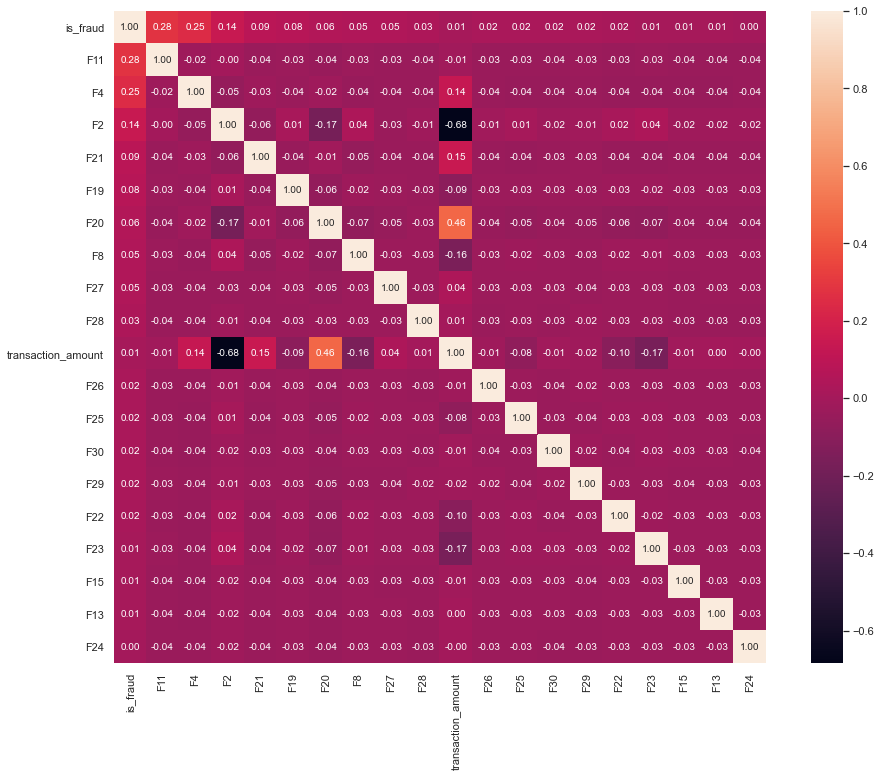

In [17]:
# Смотрим на корреляцию между 'features'
corrmat = df.drop(columns = ['relative_timestamp']).corr()
f, ax = plt.subplots(figsize=(16, 12))
cols = corrmat.nlargest(20, 'is_fraud')['is_fraud'].index
cm = np.corrcoef(corrmat[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,
                 xticklabels=cols.values)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

Как видим, корреляция между характеристиками в пределах допустимых значений. Единственное исключение корреляций между 'transaction_amount' и параметром 'F2'. Такая корреляция может влиять на часть моделей, например логистическую регрессию. В реальной задаче, я бы протестировал модель с этими двумя параметрами и модель, где бы исключил один из них, чтобы убрать взаимозависимые параметры в модели. В тестовом задании я не буду исключать ни одного с параметров. 

'relative_timestamp' ичключен из оценки корреляции, так как это больше свойство категориальное, чем количественное

In [8]:
# Готовим данные для модели 
X = df.drop(columns = ['is_fraud', 'relative_timestamp'])
# Я убрал 'relative_timestamp' с параметров. В реальной задачи, я бы создавал категориальные признаки на основании 
# timestamp. Например: день недели, час или минуту. Возможно, это бы повлияло на нашу модель и увеличило ее 
# показатели. Думаю, это стоило бы протестировать в реальной задачи, так как количество фрода может зависеть
# от времени суток. 

# Так же признак 'transaction_amount' стоило бы нормализовать, так как он может не совсем корректно повлиять на модель. 
# В тестовом задании, я не использовал нормализацию
y = df['is_fraud']

In [12]:
X.head()

,transaction_amount,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30
0,118.44,1.928977,-0.745709,-1.742981,-0.247731,-0.379232,-1.504379,0.426988,-0.560930,-1.346733,...,-0.096171,0.153526,-0.001283,0.631590,0.130582,0.758711,-0.113741,-0.063939,0.795595,-2.200074
1,1.98,2.060450,-0.136926,-1.085910,0.430300,-0.254977,-1.247417,0.104193,-0.267854,0.721569,...,-0.302288,-0.795267,0.355477,0.013651,-0.340015,0.199361,-0.078557,-0.062377,0.921937,0.216959
2,103.00,1.114014,-1.533296,0.741385,-1.385897,-1.241643,1.088519,-1.433041,0.390210,-1.711226,...,0.140363,0.783574,0.082555,-0.615175,-0.036441,-0.006456,0.109368,0.032635,0.225000,-2.467540
3,16.70,0.514410,1.389934,-1.091181,1.604760,0.460984,-0.381953,-0.599145,-2.721896,-0.567445,...,-1.670931,-0.854670,0.130428,0.789378,0.909599,-0.692159,-0.033316,0.096833,0.586722,1.187643
4,110.14,-0.849330,0.399191,-0.319642,-1.220384,1.062371,1.752440,0.558836,0.895163,-0.241615,...,0.134113,0.278606,0.198983,-0.936208,-0.477630,-0.087217,0.035566,0.090183,0.569712,-1.485808


In [13]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64

In [22]:
# Делим данные на тренировочные и тестовые 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
# Проверим распределение классов между тренировочной и тестовой выборкой 
print('В тренировочной выборке ',  y_train.value_counts()[1] / y_train.value_counts()[0] * 100, '% фрода')
print('В тестовой выборке ',  y_test.value_counts()[1] / y_test.value_counts()[0] * 100, '% фрода')

В тренировочной выборке  0.17498637830588037 % фрода
В тестовой выборке  0.19318237394238763 % фрода


Далее, мы протестируем несколько моделей и выберем лучшую из них

# Logistic Regression

In [24]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred), precision_score(y_test, y_pred),recall_score(y_test, y_pred))

0.9990847631366998 0.8547008547008547 0.6329113924050633


Важное замечание: При изменении random_state в train_test_split у меня значение recall_score менялось от 0.56 до 0.72.
Это говорит о том, что данных настолько мало, в зависимости от деления их на тестовую и тренировочную выборку зависят результаты модели. 

# LGBMclassifier

In [25]:
clf = LGBMClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred), precision_score(y_test, y_pred),
                           recall_score(y_test, y_pred))

0.9926414956190662 0.12095400340715502 0.44936708860759494


# RandomForest

In [28]:
clf = RandomForestClassifier(max_depth=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred), precision_score(y_test, y_pred),
                           recall_score(y_test, y_pred))

0.9989749347131037 0.8627450980392157 0.5569620253164557


### Вывод: Логистическая регрессия дала результаты лучше других алгоритмов по показателю recall, по этому, можем ее немного оптимизировать

# Оптимизация Логистической регрессии

In [30]:
# Выбираем оптимальные параметры для достижения максимального значения recall
# Я продемонстрирую выбор оптимальных параметров на параметре C. В модели есть и другие параметры. В реальной 
# модели нужны было бы оптимизировать все параметры, что заняло бы много времени в условиях тестового задания
C_param_range = [0.00001,0.0001,0.001,0.01,0.1,1,10,100]
pen_params = ['l2']
params_array = []
for i in C_param_range:
    for k in pen_params:
        model = LogisticRegression(penalty=k,C=i)
        result = model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        params_array.append([k, i, accuracy_score(y_test, y_pred), precision_score(y_test, y_pred),
                           recall_score(y_test, y_pred)])
max_recall = params_array[0][4]
max_ind = 0
for i,k in enumerate(params_array):
    if params_array[i][4]>max_recall:
        max_recall = params_array[i][4]
        max_ind = i
print ("penalty:", params_array[max_ind][0])
print ("C:", params_array[max_ind][1])
print("Accuracy:",params_array[max_ind][2])
print("Precision:",params_array[max_ind][3])
print("Recall:",params_array[max_ind][4])

penalty: l2
C: 100
Accuracy: 0.9991579820857638
Precision: 0.856
Recall: 0.6772151898734177


С помощью выбора параметра C, мы увеличили recall на 4%, что весьма неплохо. При оптимизации других параметров, мы бы получили еще лучшую модель.

### Выбор оптимального threshold

threshold - это параметр на основании которого модель принимает решение к какому классу соотнести объект. По умолчанию, threshold = 0.5. При изменении этого параметра, мы будем получать больше объектов одного класса и меньше другого. Нам это выгодно, так как мы хотим покрыть максимальное количество фрода. Таком образом нам лучше классифицировать не фродовую транзакцию, как фрод и лишний раз ее проверить, чем пропустить фродовою транзакцию.

Далее, я буду выбирать оптимальный threshold чтобы максимизировать recall при допустимом для нас значении precision. Выбор threshold я буду проводить на тренировочном dataset

In [32]:
def treshold_generate(k = 0.5, step = 0.01, ran = 50):
    """
        k - start point for the treshold
        step - step for the treshold
        ran - the number of generated treshold based of k and step 
    """
    treshould = []
    for i in range(0,ran):
        k = k-step
        treshould.append(k)
    return treshould

In [33]:
tresh_list = treshold_generate(k = 0.5, step = 0.01, ran = 50)

In [34]:
for i in tresh_list:
    class_distrib = {0:i, 1:1-i}
    clf = LogisticRegression(C = 100, penalty = 'l2', class_weight = class_distrib)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    print('tresh = ', i)
    print(accuracy_score(y_train, y_pred), precision_score(y_train, y_pred),
                           recall_score(y_train, y_pred), f1_score(y_train, y_pred))
    print('---')

tresh =  0.49
0.9992521155193874 0.8866396761133604 0.655688622754491 0.7538726333907058
---
tresh =  0.48
0.9992050458667615 0.885593220338983 0.625748502994012 0.7333333333333333
---
tresh =  0.47
0.9992939552106106 0.8871595330739299 0.6826347305389222 0.7715736040609138
---
tresh =  0.45999999999999996
0.9993096450948192 0.8884615384615384 0.6916167664670658 0.7777777777777778
---
tresh =  0.44999999999999996
0.9993410248632365 0.8880597014925373 0.7125748502994012 0.7906976744186046
---
tresh =  0.43999999999999995
0.999273035364999 0.8494623655913979 0.7095808383233533 0.7732463295269167
---
tresh =  0.42999999999999994
0.9992311956737759 0.8327402135231317 0.7005988023952096 0.7609756097560976
---
tresh =  0.41999999999999993
0.9993357949018337 0.8905660377358491 0.7065868263473054 0.7879799666110183
---
tresh =  0.4099999999999999
0.9993148750562221 0.8830188679245283 0.7005988023952096 0.7813021702838063
---
tresh =  0.3999999999999999
0.9993201050176249 0.8669064748201439 0.7

У нас при threshold = 0.04: recall 0.86 и precison 0.64. Это вполне неплохо. 
Теперь еще раз обучим модель, учитывая threshold и посмотрим на метрики на тестовых данных.

In [35]:
threshold = 0.04
class_distrib = {0:0.04, 1:1-0.04}
clf = LogisticRegression(C = 100, penalty = 'l2', class_weight = class_distrib)
clf.fit(X_train, y_train)

LogisticRegression(C=100, class_weight={0: 0.04, 1: 0.96})

In [36]:
# Смотрим метрики на тренировочном сете: 
y_pred = clf.predict(X_train)
print(accuracy_score(y_train, y_pred), precision_score(y_train, y_pred),
                           recall_score(y_train, y_pred))

0.9988703283369769 0.6299559471365639 0.8562874251497006


In [37]:
# Смотрим метрики на тестовом сете: 
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred), precision_score(y_test, y_pred),
                           recall_score(y_test, y_pred))

0.998694262075025 0.625615763546798 0.8037974683544303


Как видим, через выбор threshold, мы увеличили recall на 13%, что очень неплохо. У нас уменьшился precision, но это правильное решение, так как наша цель идентифицировать как можно больше фрода. 

### Интерпретация результатов модели

У нас есть 2 важных показателя.

recall = 0.8. Он говорит о том, какое количество объктов класса '1' мы обнаруживаем. Т. е. если у нас 100 фродовых транзакций, мы обнаруживаем 80 из них.

precison = 0.62. Говорит о том, какой процент их всех объектов, которые мы классифицировали как фрод действительно есть фродом. Т. е. если мы классифифировали как фрод 100 объектоы, то фродом есть 62 из них. 

Что можно еще сделать в этой модели? 
    - использовать 'relative_timestamp' как категориальный признак 
    - нормализировать 'transaction_amount'
    - пробовать создавать комбанации признаков 
    - оптимизировать другие параметры логистической регрессии, кроме 'C'
    - Убрать признак 'F2', так как он высоко корелирует с другим признаком и это может влиять на модель
    - генерировать threshold с еще меньшим шагом
Я не знаю, что обозначют признаки F1 ... F30. Хорошей идеей было бы понять лучше данные и что обозначает каждый признак. Понимание данных помогло бы создать лучшую модель. 
Так же, все наши трансформации хорошо бы поместить в Pipeline для того, чтобы в будущем быстро приводить данные к нужному нам формату. 

Малое количество объектов класса '1' и то, что в нас сильно меняются метрики модели в зависимости от деления dataset говорит о том, что данных недостаточно для того, чтобы сказать, что модель будет работать в реальном времени. Модель нестабильная и при другом делении выборки на тестовую и тренировочную может дать показатели, которые весьма отличаются от описаных выше. 

In [40]:
# Сохраняем модель
dump(clf, 'Models/logistic.joblib') 

['Models/logistic.joblib']